# Training our Network

### Introduction

Now that we understand the components of our neural network, it's finally time to train our neural network.  In training our network, we'll need to use both the `feed_forward` function which makes predictions, as well as the back propagation function which will tell us how to update our parameters, the weight matrices and bias vectors of our linear layers.

### Architecting our Network

In this lesson, we'll build a neural network that looks like the following:

$$
\begin{aligned}
z_1 & = xW_1 + b_1 \\
a_1 & = \sigma(z_1) \\
z_2 & = a_1W_2 + b_2 \\
\end{aligned}
$$

We have a linear layer, which is passed into the activation layer, here the sigmoid function.  And then the ouputs from the activation layer are fed into our second linear layer, which makes predictions.

### Constructing our Weight Matrices

Ok, let's load up our data.

In [3]:
from sklearn.datasets import make_moons
import numpy as np
np.random.seed(0)
X, y = make_moons(200, noise=0.20)

In [4]:
X.shape

(200, 2)

A quick inspection of the training data shows that we have two hundred observations, and that each observation has two features.

In [5]:
X[:1]

array([[0.74346118, 0.46465633]])

Now let's move onto constructing the weights and biases for our neural network.  Remember our network has the following architecture:

$$
\begin{aligned}
z_1 & = xW_1 + b_1 \\
a_1 & = \sigma(z_1) \\
z_2 & = a_1W_2 + b_2 \\
\end{aligned}
$$

So we need our first weight matrix to have two rows, one for each feature, and we'll decide to have three neurons in that first layer.  

For the second linear layer, because the network is fully connected, the number of inputs to each neuron equals the number of neurons in the previous layer.  Because the second layer is also our output layer, we have two columns -- one for each neuron, to predict each of the potential outputs.

> The divisor helps with the initialization weights - but is beyond the scope of these lessons.

In [72]:
import numpy as np
np.random.seed(0)

def init_model(n_features, neur_l1, neur_out):
    W1 = np.random.randn(n_features, neur_l1) / np.sqrt(n_features)
    b1 = np.zeros((1, neur_l1))
    W2 = np.random.randn(neur_l1, neur_out) / np.sqrt(neur_l1)
    b2 = np.zeros((1, neur_out))
    model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    return model

Now let's initialize the model. 

In [73]:
# n_features = 2 n_neurons_l1 = 3 n_neurons_ouput = 2 
model = init_model(2, 3, 2)
# model

> Look at the model by uncommenting the last line.

### The forward method

We can translate the above into code with the `feed_forward` method.

In [91]:
def forward(X, model):
    W1, b1, W2, b2 = tuple(model.values())
    z1 = X.dot(W1) + b1 
    a1 = sigma(z1)
    z2 = a1.dot(W2) + b2
    return (z1, a1, z2)

> Here we return the prediction $z_2$ from the model, as well as $z_1$ and $a_1$ as we will need them later when in computing the gradients.

In [92]:
forward(X[:1], model)

(array([[ 1.46282768, -1.8280879 , -4.52356424]]),
 array([[0.81196478, 0.13846622, 0.01073382]]),
 array([[0.94742501, 0.05257499]]))

> The last array shows our predictions ($z_2$) for our neural network.

### Our Data and a Loss Function

Let's quickly walk through our loss, feel free to break down the code further if you prefer.

In [93]:
def scalar_to_index(val, num_options = 2):
    y_ar = [0]*num_options
    y_ar[val] = 1
    return y_ar

Y = np.stack([scalar_to_index(y_val) for y_val in y])

Above we translate the original form of our targets:

In [94]:
y[:3]

array([0, 1, 1])

To the following:

In [95]:
Y[:3]

array([[1, 0],
       [0, 1],
       [0, 1]])

Now each observation has two columns to represent the target.  Above, the `[1, 0]` in the first row means that the target was a 0.  As there was a 1 in the 0 index.  And that the first observation **was not** a `1`, as there was a 0 in the 1 index.

We use this in our calculate loss function, so that we can compare our predictions to the observations.

In [96]:
def calculate_loss(Y, Y_hat):
    total_error = ((Y - Y_hat)**2).sum()
    return total_error

This is the loss function that we'll use to see how well our function is doing. 

### Moving to Gradients

We go through the calculation of gradients in a dedicated lesson.  Let's copy and paste the code from there below.

In [97]:
def backwards(z1, a1, W2, Y, Y_hat, X):
    dloss = (Y_hat - Y)
    dW2 = (a1.T).dot(dloss)
    db2 = np.sum(dloss, axis=0, keepdims=True)
    da1 = dloss.dot(W2.T) 
    d_sigma = sigma(z1)*(1 - sigma(z1))*da1
    dW1 = np.dot(X.T, d_sigma)
    db1 = np.sum(d_sigma, axis=0)
    return (dW1, db1, dW2, db2)

We also need to define the sigmoid function (named `sigma`), as our backwards function relies on it.  

In [98]:
def sigma(x): return 1/(1 + np.exp(-x))

One more note about the above functin, note that it returns a tuple of the gradients of all of our parameters -- $W1$, $b1$, $W2$, $b2$.  It does not *update* the parameters itself.  It just calculates the derivatives.

The updating occurs in the `step` function.  The step function takes in the parameters of the current version of the neural network, as well as the amount to update them by, and updates the parameters accordingly.  We also pass through our learning rate, eta, $\eta$.

In [99]:
eta = .001
def step(W1, b1, W2, b2, dW2, db2, dW1, db1, eta):
    W1 = W1 -eta * dW1
    b1 = b1 -eta * db1
    W2 = W2 -eta * dW2
    b2 = b2 -eta * db2
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    return model

### Train Model

In [100]:
def train_model(model, X, Y, n_steps=20000, print_loss=False):
    for i in range(0, n_steps):          
        W1, b1, W2, b2 = tuple(model.values())
        (z1, a1, y_hats) = forward(X, model)
        dW1, db1, dW2, db2 = backwards(z1, a1, W2, Y, y_hats, X)
        model = step(W1, b1, W2, b2, dW2, db2, dW1, db1, eta)
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(Y, y_hats)))
    return model

Let's take a moment to follow the procedure here.  We begin by initializing the model, and then take a number of steps, just like we did with gradient descent in one dimension.  In each step, we start with the parameters of the model.  We make predictions with the model with the `forward` function.  Then with the `backwards` function we calculate the gradient that minimizes the cost curve.  Then we take update our parameters by an amount proportional to the gradient in the step function.  After a certain number of steps we return the model, which contains our parameters.

### Executing the model

Ok, time to run the model.  Note that we just like in gradient descent, we take multiple step sizes to minimize our cost function.  We specify the number of steps, but feel free to change this number.

In [101]:
initial_model = init_model(2, 3, 2)

In [102]:
model = train_model(initial_model, X, Y, n_steps=30000, print_loss=True)

Loss after iteration 0: 374.340779
Loss after iteration 1000: 38.752968
Loss after iteration 2000: 38.209139
Loss after iteration 3000: 37.877237
Loss after iteration 4000: 37.365485
Loss after iteration 5000: 35.634415
Loss after iteration 6000: 30.729352
Loss after iteration 7000: 25.266135
Loss after iteration 8000: 22.975696
Loss after iteration 9000: 22.245780
Loss after iteration 10000: 21.937305
Loss after iteration 11000: 21.771401
Loss after iteration 12000: 21.666094
Loss after iteration 13000: 21.585570
Loss after iteration 14000: 21.509572
Loss after iteration 15000: 21.422609
Loss after iteration 16000: 21.307723
Loss after iteration 17000: 21.142437
Loss after iteration 18000: 20.899184
Loss after iteration 19000: 20.554797
Loss after iteration 20000: 20.108502
Loss after iteration 21000: 19.595064
Loss after iteration 22000: 19.076386
Loss after iteration 23000: 18.612455
Loss after iteration 24000: 18.234841
Loss after iteration 25000: 17.943083
Loss after iteration 260

Now let's see how well we did.

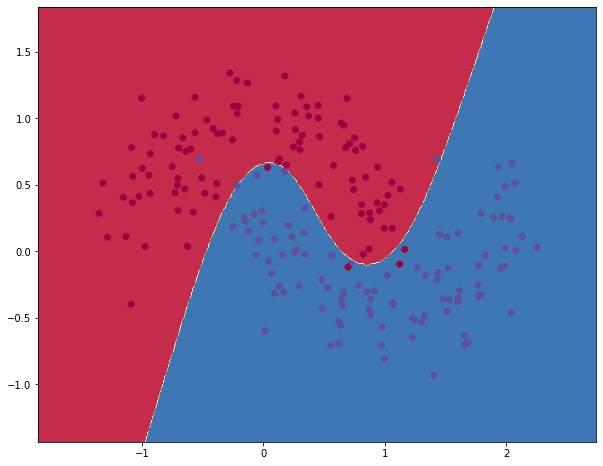

In [103]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

def plot_decision_boundary(pred_func, X):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

def predict(model, x):
    W1, b1, W2, b2 = tuple(model.values())
    (z1, a1, y_hats) = forward(x, model)
    return np.argmax(y_hats, axis=1)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x), X)
# plt.title("Decision Boundary for hidden layer size 3")

We can train the fit the model to the data even more by increasing the number of `epochs`.

### Summary

In this lesson, we built our neural network.  The heart of the code is our train model function: 

```python
def train_model(model, X, Y, n_steps=20000, print_loss=False):
    for i in range(0, n_steps):          
        W1, b1, W2, b2 = tuple(model.values())
        (z1, a1, y_hats) = forward(X, W1, b1, W2, b2)
        dW1, db1, dW2, db2 = backwards(z1, a1, W2, Y, y_hats, X)
        model = step(W1, b1, W2, b2, dW2, db2, dW1, db1, eta)
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(Y, y_hats)))
    return model
```

See how well you can explain each of the steps involved.  Great work!

### Resources

* [Code derived from wildml blog post](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/)

* [gradient of bias](https://datascience.stackexchange.com/questions/20139/gradients-for-bias-terms-in-backpropagation)

* If interested in a different loss function, look at [cross entropy](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a)